In [2]:
# import ML models
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

In [5]:
train = pd.read_csv('/Users/Muyan/Desktop/ML_Project/train.csv')
test = pd.read_csv('/Users/Muyan/Desktop/ML_Project/test.csv')

In [6]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [7]:
print(train.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [60]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [8]:
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 100)
plt.rcParams['figure.figsize']= [8.0, 4.0]

In [9]:
# categorical features
categorical_feat1 = train.columns[train.dtypes=='object'].tolist()

# numerical features
numeric_feat1 = train.columns[(train.dtypes=='int64')|(train.dtypes=='float64')].drop('SalePrice').tolist()

print('categorical features:\n{}\n{}'.format(sorted(categorical_feat1), len(categorical_feat1)))
print('\nnumerical features:\n{}\n{}'.format(sorted(numeric_feat1), len(numeric_feat1)))

categorical features:
['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities']
43

numerical features:
['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Id', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF', 'Overall

In [11]:
def check_missingness(df):
    missing_features = df.columns[df.isna().any()]

    # how bad is the missing ?
    missing = {}
    for i in missing_features:
        missing[i]= df[i].isna().sum()
    missing = pd.Series(missing).sort_values(ascending=False)
    return missing

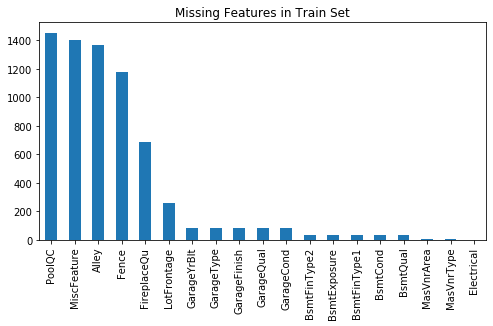

In [12]:
check_missingness(train)[:20].plot(kind='bar')
plt.title('Missing Features in Train Set')
plt.savefig('train_missing.png',bbox_inches='tight')

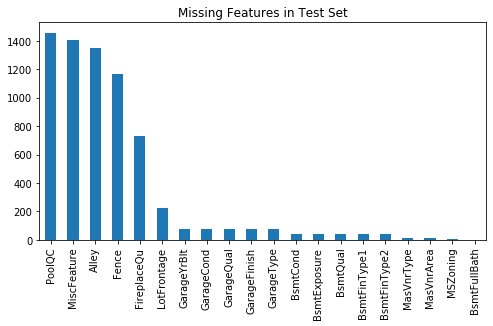

In [13]:
check_missingness(test)[:20].plot(kind='bar')
plt.title('Missing Features in Test Set')

plt.savefig('test_missing.png',bbox_inches='tight')

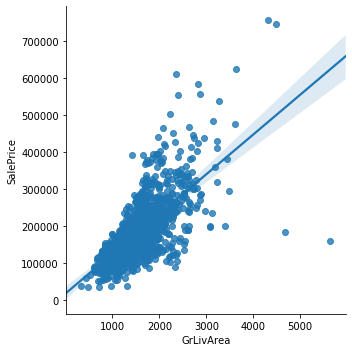

In [14]:
sns.lmplot(x='GrLivArea', y= 'SalePrice', data=train)
plt.savefig('saleprice_grlivarea.png',bbox_inches='tight')

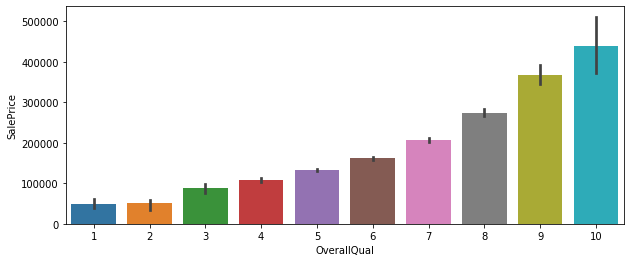

In [15]:
plt.rcParams['figure.figsize']= [10.0, 4.0]
sns.barplot(train.OverallQual, train.SalePrice)
plt.savefig('overallqual.png',bbox_inches='tight')

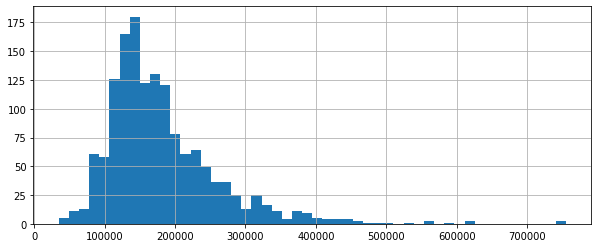

In [16]:
train.SalePrice.hist(bins=50)
plt.savefig('saleprice.png',bbox_inches='tight')

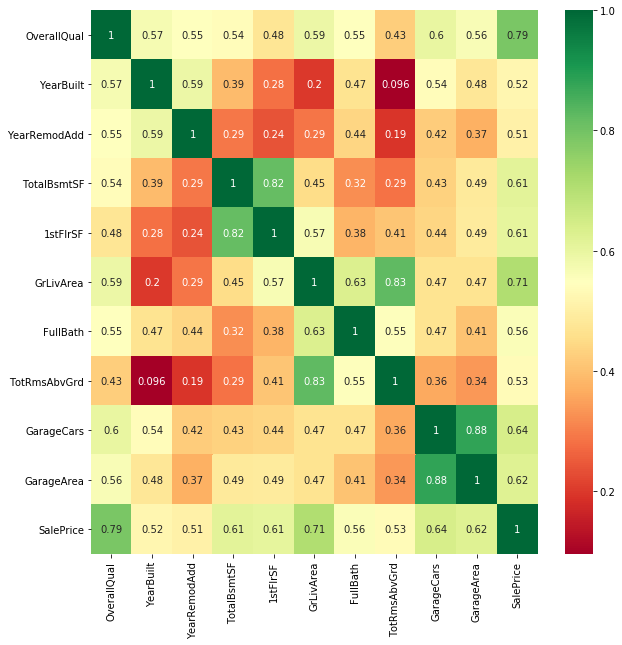

In [17]:
plt.rcParams['figure.figsize']= [10.0, 10.0]
corr=train.corr()
sns.heatmap(train[corr[corr['SalePrice'].abs()>0.5].index].corr(),annot=True,cmap="RdYlGn")
plt.savefig('heatmap.png',bbox_inches='tight')

In [ ]:
# Data Processing

In [69]:
def process_missing(df):
   
    # fill LotFrontage missings with median value in the same neighborhood
    df['LotFrontage'] = df[['Neighborhood','LotFrontage']].groupby('Neighborhood').transform(lambda x: x.fillna(x.median()))

    # impute MSZoning missings as the most frequent value in the same MSSubClass
    df['MSZoning'] = df[['MSSubClass', 'MSZoning']].groupby('MSSubClass').transform(lambda x: x.fillna(x.mode()[0]))

    df['Utilities'] = df['Utilities'].fillna(df['Utilities'].mode()[0])

    df['Exterior1st'] = df['Exterior1st'].fillna('Wd Sdng')
    df['Exterior2nd'] = df['Exterior2nd'].fillna('Wd Sdng')

    df['Electrical'] = df.groupby('Neighborhood')['Electrical'].transform(lambda x: x.fillna(x.mode()[0]))

    df['Functional'] = df['Functional'].fillna(df['Functional'].mode()[0])
    df['KitchenQual'] = df.groupby('Neighborhood')['KitchenQual'].transform(lambda x: x.mode()[0])
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
    
    df[numeric_feat1] = df[numeric_feat1].fillna(0)
    df[categorical_feat1] = df[categorical_feat1].fillna('None')

    #print(df.head())
    return df

In [70]:
all_data = pd.concat([train.copy().drop(columns=['SalePrice']), test.copy()], axis=0)

In [71]:
all_data = process_missing(all_data)

In [72]:
all_data.isnull().any().sum()

0

In [ ]:
# Feature Engineering

In [25]:
def Feat_engineering1(data):
    df = data.copy()
    # drop 'Id', 'Street', 'Utilities','PoolQC'
    to_remove=set(['Id', 'Street', 'Utilities','PoolQC', 'PoolArea', 'HalfBath', 'BsmtHalfBath', 'FullBath', 'BsmtFullBath',\
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'WoodDeckSF','TotalBsmtSF', '1stFlrSF',\
                  '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'YearBuilt', 'YearRemodAdd'])
    # convert PoolArea to binary
    df['HasPool'] = df['PoolArea'].apply(lambda x: 'Yes' if x>0 else 'No')

    # convert to categorical
    df[['KitchenAbvGr', 'TotRmsAbvGrd', 'BedroomAbvGr', 'GarageCars']] = df[['KitchenAbvGr', 'TotRmsAbvGrd', 'BedroomAbvGr', 'GarageCars']].astype(str)

    # combine features of 'HalfBath', 'BsmtHalfBath', 'FullBath', 'BsmtFullBath'
    df['TotalBath'] = df['HalfBath']/2 + df['BsmtHalfBath']/2 + df['FullBath'] + df['BsmtFullBath']
    df['TotalBath'] = df['TotalBath'].astype('str')

    # combine features of 'OpenPorchSF', 'EnclosedPorch', 'X3SsnPorch', 'ScreenPorch', 'WoodDeckSF'
    df['Total_PorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch'] + df['WoodDeckSF']

    # combine features of TotalSF = TotalBsmtSF + X1stFlrSF + X2ndFlrSF
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

    # combine features of 'BsmtFinSF1', 'BsmtFinSF2', 'X1stFlrSF', 'X2ndFlrSF'
    df['TotalFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']

    # combine 'YearBuilt', 'YearRemodAdd'
    df['YearBuildRemod'] = df['YearBuilt'] + df['YearRemodAdd']

    # add new features
    df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 'Yes' if x>0 else 'No')

    df['Has2ndFlr'] = df['2ndFlrSF'].apply(lambda x: 'Yes' if x>0 else 'No')

    df['HasBasement'] = df['TotalBsmtSF'].apply(lambda x: 'Yes' if x>0 else 'No')

    new_columns = list(set(df.columns).difference(to_remove))
    

    return df[new_columns]

In [26]:
def Feat_engineering(data):
    df = data.copy()
    
     # convert to categorical
    to_categorical = ['KitchenAbvGr', 'TotRmsAbvGrd', 'BedroomAbvGr', 
                      'GarageCars', 'HalfBath','BsmtHalfBath',
                      'FullBath','BsmtFullBath','Fireplaces']
    
    df[to_categorical] = df[to_categorical].astype(str)

    # drop features
    to_remove=set(['Id', 'Street', 'Utilities','PoolQC'])
    new_columns = list(set(df.columns).difference(to_remove))
    
    return df[new_columns]

In [27]:
all_data = Feat_engineering(all_data)

In [28]:
categorical_feat = all_data.columns[all_data.dtypes=='object']
numeric_feat = all_data.columns[all_data.dtypes!='object']

In [29]:
print(len(categorical_feat))
print(len(numeric_feat))

49
27


In [30]:
# skew transform

In [31]:
def skew_transform(data):
    df = data.copy()
    skew_features = df.apply(lambda x: skew(x)).sort_values(ascending=False)

    high_skew = skew_features[skew_features > 0.75]
    skew_index = high_skew.index
    print(skew_index)

    df[skew_index] = df[skew_index].apply(lambda x: boxcox1p(x, boxcox_normmax(x+1)))
    return df

In [ ]:
all_data[numeric_feat] = skew_transform(all_data[numeric_feat])

In [32]:
salePrice = np.log(train.SalePrice)

In [33]:
plt.rcParams['figure.figsize']= [10.0, 4.0]

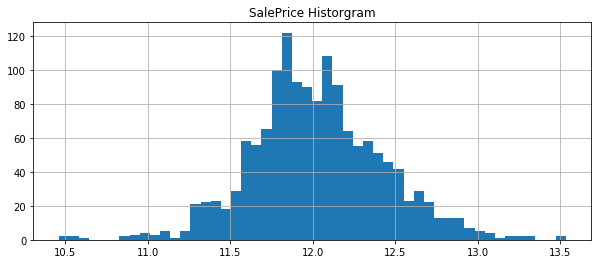

In [34]:
salePrice.hist(bins=50)
plt.title('SalePrice Historgram')
plt.savefig('saleprice_log.png',bbox_inches='tight')

In [35]:
numeric_feat

Index(['LowQualFinSF', 'GrLivArea', 'PoolArea', 'GarageArea', 'WoodDeckSF',
       'MasVnrArea', 'OpenPorchSF', 'GarageYrBlt', 'TotalBsmtSF', 'YearBuilt',
       'EnclosedPorch', 'OverallQual', 'OverallCond', '2ndFlrSF',
       'YearRemodAdd', 'LotFrontage', 'BsmtFinSF2', 'MoSold', '3SsnPorch',
       'ScreenPorch', 'BsmtUnfSF', 'MiscVal', '1stFlrSF', 'MSSubClass',
       'BsmtFinSF1', 'LotArea', 'YrSold'],
      dtype='object')

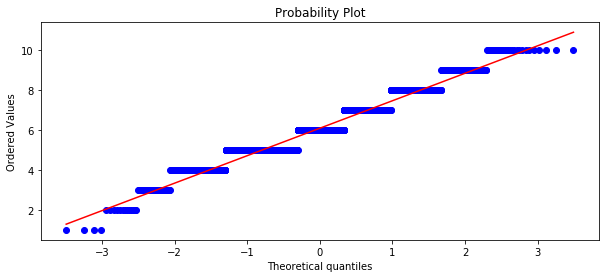

In [36]:
probplot(all_data['OverallQual'], plot=plt)
plt.savefig('overallqual transformed.png',bbox_inches='tight')

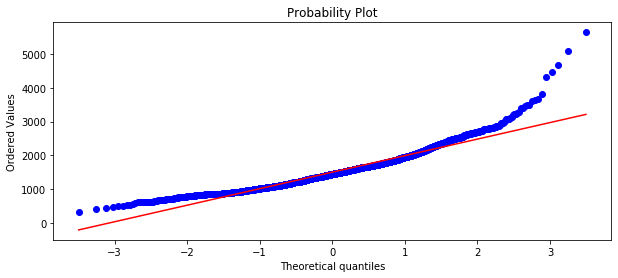

In [37]:
probplot(all_data['GrLivArea'], plot=plt)
plt.savefig('GrLivArea transform.png',bbox_inches='tight')

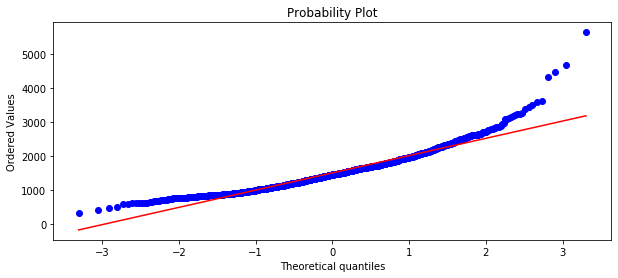

In [38]:
probplot(train['GrLivArea'], plot=plt)
plt.savefig('GrLivArea before.png',bbox_inches='tight')

In [39]:
from scipy.stats import zscore
z_score = {}
for i in numeric_feat:
    z_score[i] = zscore(all_data[i])
z_score = pd.DataFrame(z_score)
z_score = z_score.head(train.shape[0])
for i in ['OverallQual','GrLivArea']:
    print(i,z_score[np.abs(z_score[i])>3.5][i].sort_values(ascending=False))

OverallQual 533   -3.610024
375   -3.610024
Name: OverallQual, dtype: float64
GrLivArea 1298    8.184846
523     6.275620
1182    5.880335
691     5.564108
1169    4.202352
185     4.164800
304     3.937511
1268    3.846595
635     3.743821
769     3.514556
Name: GrLivArea, dtype: float64


In [46]:
# choose the highest z_score from two ends as outlier
# two outliers case
outliers = [1298, 533] 

# four outliers case
outliers = [1298, 533, 523, 1100]